*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). January 2018.*

# Tutorial N5: Coherent Synchrotron Radiation (CSR)

*Second-order tracking with CSR effects using 200,000 particles.*

As an example, we simulate the **BC2 bunch compressor** of the European XFEL accelerator.

The CSR module in Ocelot uses a fast **projected 1D model** based on the approach from the [CSRtrack code](https://www.desy.de/xfel-beam/csrtrack/), following:

* [Saldin et al, Radiative interaction of electrons in a bunch moving in an undulator, 1998](http://www.sciencedirect.com/science/article/pii/S0168900298006238), 
* [M. Dohlus, Two Methods for the Calculation of CSR Fields, 2003](https://flash.desy.de/sites2009/site_vuvfel/content/e403/e1642/e740/e741/infoboxContent746/fel2003-05.pdf), 
* [M. Dohlus, T. Limberg, CSRtrack: FASTER CALCULATION OF 3-D CSR EFFECTS, 2004](https://accelconf.web.cern.ch/f04/papers/MOCOS05/MOCOS05.PDF). 

The particle tracking uses matrices up to the second order. CSR wake is calculated continuously through beam lines of arbitrary flat geometry. The transverse self-forces are neglected completely. The method calculates the longitudinal self-field of a one-dimensional beam that is obtained by a projection of the ‘real’ three-dimensional beam onto a reference trajectory. A smooth one-dimensional charge density is calculated by binning and filtering, which is crucial for the stability and accuracy of the simulation, since the instability is sensitive to high frequency components in the charge density.

---

### This example covers:

- Initialization and placement of the [**`CSR` class**](https://www.ocelot-collab.com/docs/docu/physics-processes/csr)  
- Second-order matrix-based [**tracking**](https://www.ocelot-collab.com/docs/tutorial/tutorial-beam-dynamics/tracking/) with CSR effects  
- Use of the [**`Navigator`**](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/navigator) to assign physics processes  
- Lattice construction with [**`MagneticLattice`**](https://www.ocelot-collab.com/docs/docu/OCELOT%20fundamentals/magnet-lattice/)

---

### Requirements

- `in.fmt1`: Initial beam distribution in CSRtrack format  
  (obtained from an s2e simulation performed with ASTRA + CSRtrack)

- `out.fmt1`: Output distribution after BC2 bunch compressor  
  (reference output from CSRtrack used for comparison)

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
from time import time 

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

initializing ocelot...


### Load beam distribution from CSRtrack format

Text(0, 0.5, 'dE/pc')

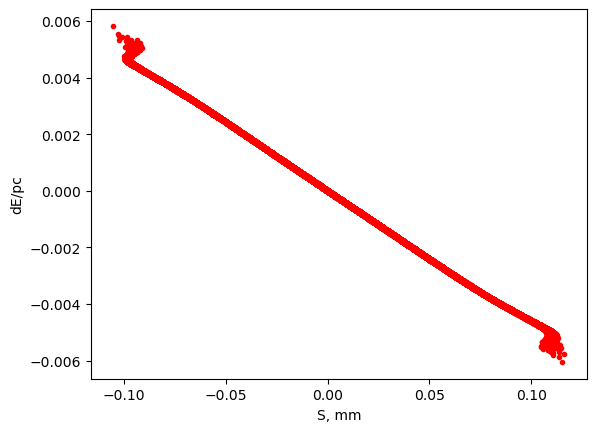

In [2]:
# load and convert CSRtrack file to OCELOT beam distribution
# p_array_i = csrtrackBeam2particleArray("in.fmt1", orient="H")

# save ParticleArray to compresssed numpy array 
# save_particle_array("test.npz", p_array_i)
p_array_i = load_particle_array("csr_beam.npz")

# show the longitudinal phase space
plt.plot(-p_array_i.tau()*1000, p_array_i.p(), "r.")
plt.xlabel("S, mm")
plt.ylabel("dE/pc")

### create BC2 lattice

In [3]:
b1 = Bend(l = 0.5001, angle=-0.0336, e1=0.0, e2=-0.0336, gap=0, tilt=0, eid='BB.393.B2')
b2 = Bend(l = 0.5001, angle=0.0336, e1=0.0336, e2=0.0, gap=0,  tilt=0, eid='BB.402.B2')
b3 = Bend(l = 0.5001, angle=0.0336, e1=0.0, e2=0.0336, gap=0, tilt=0,  eid='BB.404.B2')
b4 = Bend(l = 0.5001, angle=-0.0336, e1=-0.0336, e2=0.0, gap=0,  tilt=0, eid='BB.413.B2')

d_slope = Drift(l=8.5/np.cos(b2.angle))

start_csr = Marker()
stop_csr = Marker()

# define cell frome the bends and drifts
cell = [start_csr, Drift(l=0.1), b1 , d_slope  , b2, Drift(l=1.5), 
        b3, d_slope, Marker(), b4, Drift(l= 1.), stop_csr]

#### Initialization tracking method and MagneticLattice object

In [4]:
# for second order tracking we have to choose SecondTM 
method = {"global": SecondTM}

# for first order tracking uncomment next line
# method = {"global": TransferMap}

lat = MagneticLattice(cell, method=method)

### Create CSR object 

In [5]:
csr = CSR(n_bin=300, m_bin=5, sigma_min=.2e-6)

### Track particles with and without CSR effect

In [6]:
navi = Navigator(lat)

# track witout CSR effect 
p_array_no = deepcopy(p_array_i)
print("\n tracking without CSR effect .... ")
start = time()
tws_no, p_array_no = track(lat, p_array_no, navi)
print("\n time exec:", time() - start, "sec")

# again create Navigator with needed step in [m]
navi = Navigator(lat)
navi.unit_step = 0.5 # m

# add csr process to navigator with start and stop elements
navi.add_physics_proc(csr, start_csr, lat.sequence[-1])

# tracking 
start = time()
p_array_csr = deepcopy(p_array_i)
print("\n tracking with CSR effect .... ")
tws_csr, p_array_csr = track(lat, p_array_csr, navi)
print("\n time exec:", time() - start, "sec")


 tracking without CSR effect .... 
z = 21.610000676107052 / 21.610000676107052. Applied: 
 time exec: 0.5548112392425537 sec

 tracking with CSR effect .... 
z = 21.610000676107052 / 21.610000676107052. Applied: CSR
 time exec: 12.593474864959717 sec


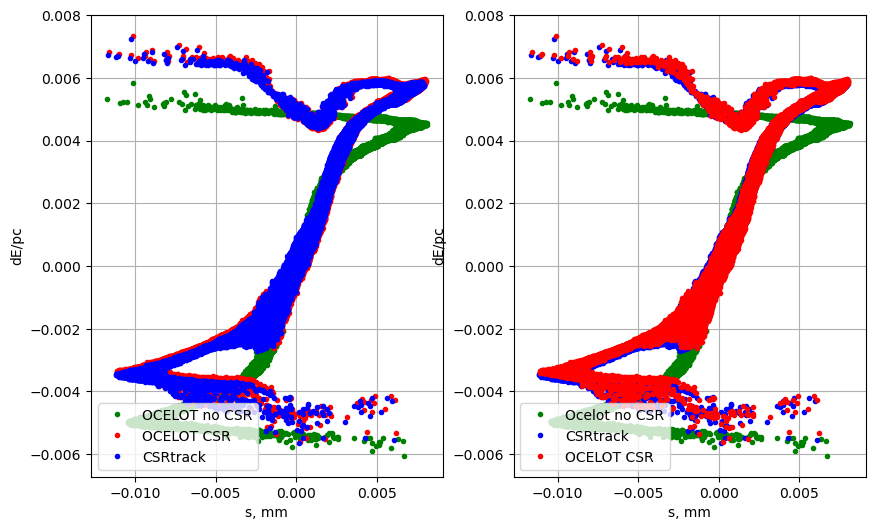

In [7]:
# recalculate reference particle 
from ocelot.cpbd.beam import *

recalculate_ref_particle(p_array_csr)
recalculate_ref_particle(p_array_no)

# load and convert CSRtrack file to OCELOT beam distribution 
# distribution after BC2
# p_array_out = csrtrackBeam2particleArray("out.fmt1", orient="H")
# save ParticleArray to compresssed numpy array 
# save_particle_array("scr_track.npz", p_array_out)
p_array_out = load_particle_array("scr_track.npz")

# standard matplotlib functions 

plt.figure(2, figsize=(10, 6))
plt.subplot(121)
plt.plot(p_array_no.tau()*1000, p_array_no.p(), 'g.', label="OCELOT no CSR")
plt.plot(p_array_csr.tau()*1000, p_array_csr.p(), 'r.', label="OCELOT CSR")
plt.plot(p_array_out.tau()*1000, p_array_out.p(), 'b.', label="CSRtrack")
plt.legend(loc=3)
plt.xlabel("s, mm")
plt.ylabel("dE/pc")
plt.grid(True)


plt.subplot(122)
plt.plot(p_array_no.tau()*1000, p_array_no.p(), 'g.', label="Ocelot no CSR")
plt.plot(p_array_out.tau()*1000, p_array_out.p(), 'b.', label="CSRtrack")
plt.plot(p_array_csr.tau()*1000, p_array_csr.p(), 'r.', label="OCELOT CSR")
plt.legend(loc=3)
plt.xlabel("s, mm")
plt.ylabel("dE/pc")
plt.grid(True)
plt.savefig("arcline_traj.png")

### display trajectory of the reference particle in CSR region 

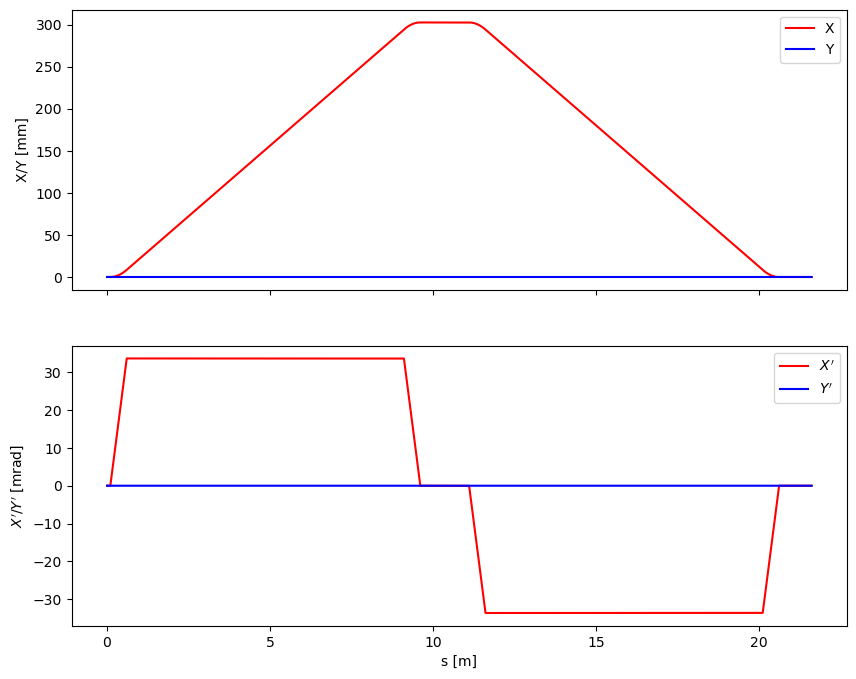

In [8]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(211)
# ax1.plot(self.csr_traj[0, :], self.csr_traj[0, :] -self.csr_traj[3, :], "r", label="X")
ax1.plot(csr.csr_traj[0, :], csr.csr_traj[1, :] * 1000, "r", label="X")
ax1.plot(csr.csr_traj[0, :], csr.csr_traj[2, :] * 1000, "b", label="Y")
plt.legend()
plt.ylabel("X/Y [mm]")
plt.setp(ax1.get_xticklabels(), visible=False)
ax3 = plt.subplot(212, sharex=ax1)
ax3.plot(csr.csr_traj[0, :], csr.csr_traj[1 + 3, :] * 1000, "r", label=r"$X'$")
ax3.plot(csr.csr_traj[0, :], csr.csr_traj[2 + 3, :] * 1000, "b", label=r"$Y'$")
plt.legend()
plt.ylabel(r"$X'/Y'$ [mrad]")
plt.xlabel("s [m]")
plt.show()